# **Image Classification Using the EfficientNetV2-XL Model**

In this notebook, the [EfficientNetV2-XL](https://arxiv.org/abs/2104.00298) model is fine-tuned using the [CIFAR-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html) dataset. This dataset consists of 60,000 RGB images across 10 classes, with 50,000 used for training and 10,000 for testing. The EfficientNetV2-XL model is available on [TensorFlow Hub](https://www.kaggle.com/models?tfhub-redirect=true), a repository for pre-trained TensorFlow models. In this notebook, the `efficientnetv2-xl-21k-ft1k` version is specifically used, which is pre-trained on the [ImageNet21K](https://github.com/Alibaba-MIIL/ImageNet21K) dataset and fine-tuned on [ImageNet1K](https://www.image-net.org/download.php). Compared to earlier versions like [EfficientNet](https://arxiv.org/abs/1905.11946), EfficientNetV2 provides faster training with fewer parameters while achieving superior performance.

Better results have been achieved in the notebook [ImageClassification_ConvNeXTV2_CIFAR-10](https://github.com/JersonGB22/ImageClassification-TensorFlow/blob/main/VisionTransformerModels/ImageClassification_ConvNeXTV2_CIFAR-10.ipynb), reaching an accuracy of **99.32%** on the test dataset.

## **Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
epochs = 50
model_url = "gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k-ft1k/feature-vector"

## **Prepare the dataset for training**

### **Load the dataset**

In [ ]:
(train_dataset, test_dataset), info = tfds.load("cifar10", split=["train", "test"], as_supervised=True, with_info=True)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.6HTYZS_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.6HTYZS_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpn6flz8_ytfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

In [ ]:
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
class_names = [name.capitalize() for name in class_names]

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 10
Class names: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


### **Preprocessing and data augmentation**

To combat overfitting, it is essential to use data augmentation techniques, especially when the training dataset is relatively small. Data augmentation enhances the model’s ability to generalize in image classification tasks. For this purpose, TensorFlow layers such as [``RandomFlip``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [``RandomTranslation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation), [``RandomRotation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation), and [``RandomZoom``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) will be used. These layers should only be applied to the training dataset during preprocessing, controlled by setting the ``training=True`` parameter.

Regarding image preprocessing, the [``Resizing``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) layer is used to resize images and ensure compatibility with the model, and the [``Rescaling``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer is used to normalize the images to the ``[0;1]`` range. These layers operate independently of the ``training`` parameter, so they are applied to both the training and testing datasets.

In [ ]:
original_size = info.features["image"].shape
new_size = (224, 224, 3)

original_size, new_size

((32, 32, 3), (224, 224, 3))

In [ ]:
def function_data_augmentation(input_shape, output_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      tf.keras.layers.Resizing(output_shape[0], output_shape[1]),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
      tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
      tf.keras.layers.RandomZoom(0.2, fill_mode="nearest"),
      tf.keras.layers.Rescaling(1/255)
  ], name="data_augmentation")

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
data_augmentation = function_data_augmentation(original_size, new_size)

In [ ]:
def prepare_dataset(dataset, training=True):
  if training:
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      batch(batch_size).
      map(lambda x, y : (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE).
      prefetch(AUTOTUNE)
  )

  return dataset

In [ ]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset, training=False)

In [ ]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(128, 224, 224, 3) (128,)


(0.0, 1.0)

**Function to display and save images**

In [ ]:
def show_images(images, labels, predictions=None, num_examples=36, random=True,
                cmap=None, axis="off", save=False, path=""):

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.25*n, 1.25*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.11, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path)

  plt.show()

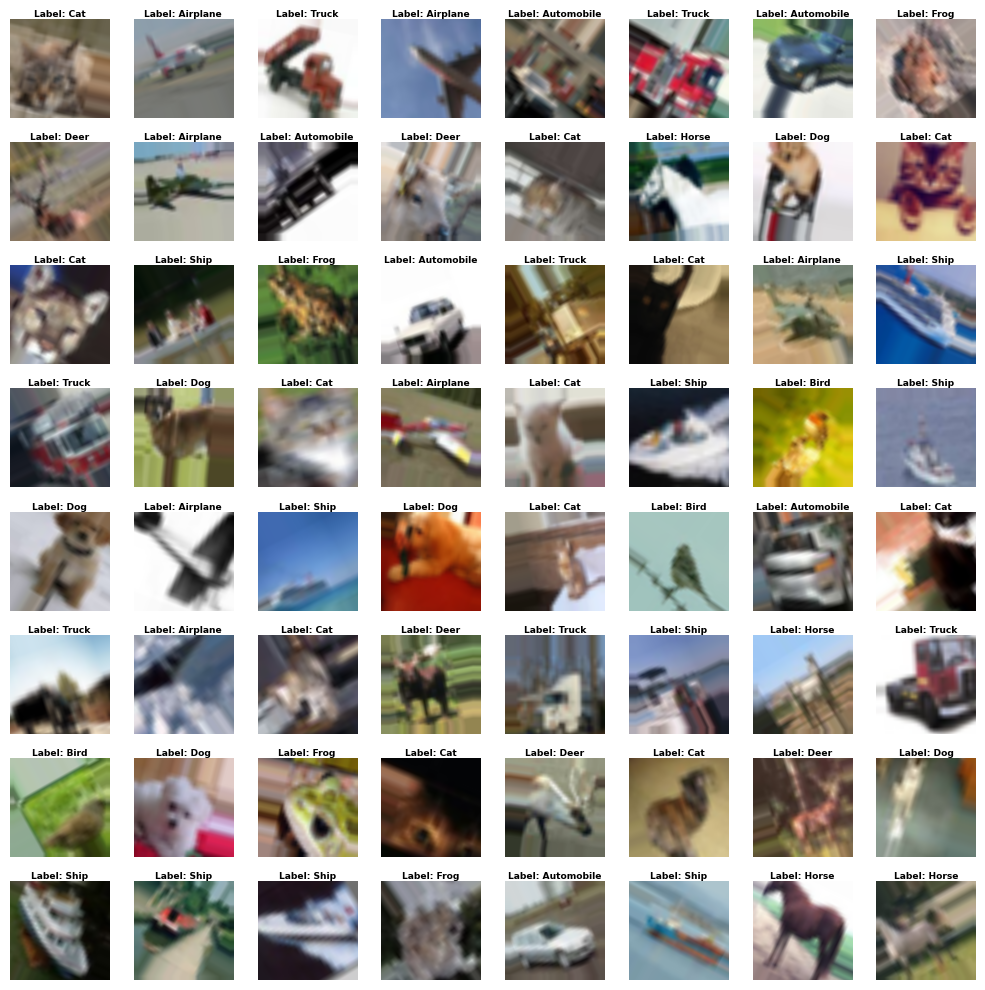

In [ ]:
# Some images from the training dataset after data augmentation
show_images(images, labels, num_examples=64, random=False)

## **Model building and training**

Since the EfficientNetV2-XL model has over 200 million parameters, it is essential to use Google Colab's TPU to significantly accelerate the training time during fine-tuning. Additionally, a ``LearningRateSchedule`` is employed to gradually decrease the learning rate as training progresses, helping to prevent overfitting.

In [ ]:
# TPU setup

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
def build_model(model_url, image_size, dropout_rate=0.1, name=None):
  return tf.keras.Sequential([
      tf.keras.Input(shape=image_size),
      hub.KerasLayer(model_url, trainable=True),
      tf.keras.layers.Dropout(dropout_rate),
      tf.keras.layers.Dense(num_classes, activation="softmax")
  ], name=name)

In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = build_model(model_url, new_size, name="EfficientNetV2-XL")

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=5e-3,
      decay_steps=len(train_dataset)*2.4,
      decay_rate=0.97
  )
  model.compile(
      optimizer=tf.keras.optimizers.SGD(lr_schedule, momentum=0.9),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
      steps_per_execution=50
  )

model.summary()

Model: "EfficientNetV2-XL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 207628642 (792.04 MB)
Trainable params: 206851618 (789.08 MB)
Non-trainable params: 777024 (2.96 MB)
_________________________________________________________________


In [ ]:
# Callback to stop training early if validation accuracy does not improve for 5 epochs
patience = 5
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=patience,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/50
391/391 [==============================] - 689s 2s/step - loss: 0.7180 - accuracy: 0.7600 - val_loss: 0.1085 - val_accuracy: 0.9682
Epoch 2/50
391/391 [==============================] - 114s 290ms/step - loss: 0.2605 - accuracy: 0.9157 - val_loss: 0.0764 - val_accuracy: 0.9747
Epoch 3/50
391/391 [==============================] - 114s 291ms/step - loss: 0.1868 - accuracy: 0.9400 - val_loss: 0.0586 - val_accuracy: 0.9810
Epoch 4/50
391/391 [==============================] - 113s 290ms/step - loss: 0.1467 - accuracy: 0.9510 - val_loss: 0.0570 - val_accuracy: 0.9816
Epoch 5/50
391/391 [==============================] - 114s 292ms/step - loss: 0.1215 - accuracy: 0.9597 - val_loss: 0.0472 - val_accuracy: 0.9852
Epoch 6/50
391/391 [==============================] - 114s 291ms/step - loss: 0.1004 - accuracy: 0.9671 - val_loss: 0.0465 - val_accuracy: 0.9855
Epoch 7/50
391/391 [==============================] - 108s 277ms/step - loss: 0.0870 - accuracy: 0.9710 - val_loss: 0.0524 - va

**Save the model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/ImageClassification_EfficientNetV2-XL_CIFAR-10"
model.save(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.004914081655442715, 0.9983800053596497]
[0.04577222838997841, 0.9904000163078308]


In [ ]:
(0.9983800053596497-0.9904000163078308) * 100

0.7979989051818848

### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.4 MB/s eta 0:00:00


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history.history, metric="loss", renderer=None, with_patience=True):
  epochs = len(history["loss"])
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

  last_epoch = epochs-patience if with_patience else epochs
  fig.add_vline(
      x=last_epoch, line=dict(color="red", width=2, dash="dash"),
      annotation_text="End of Training", annotation_position="top left",
      annotation=dict(font_size=12, font_color="red")
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(metric="accuracy")
plot_metrics()

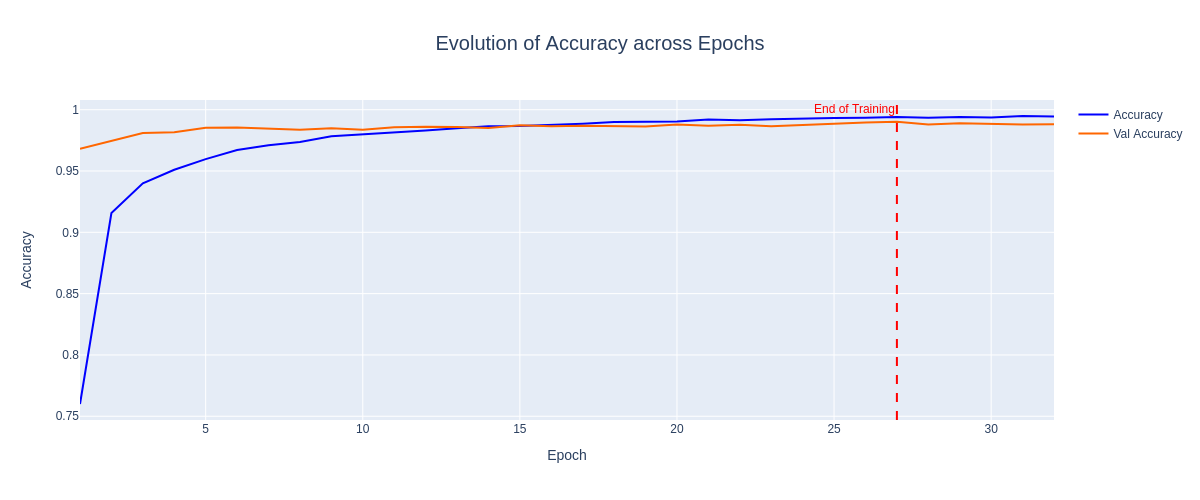

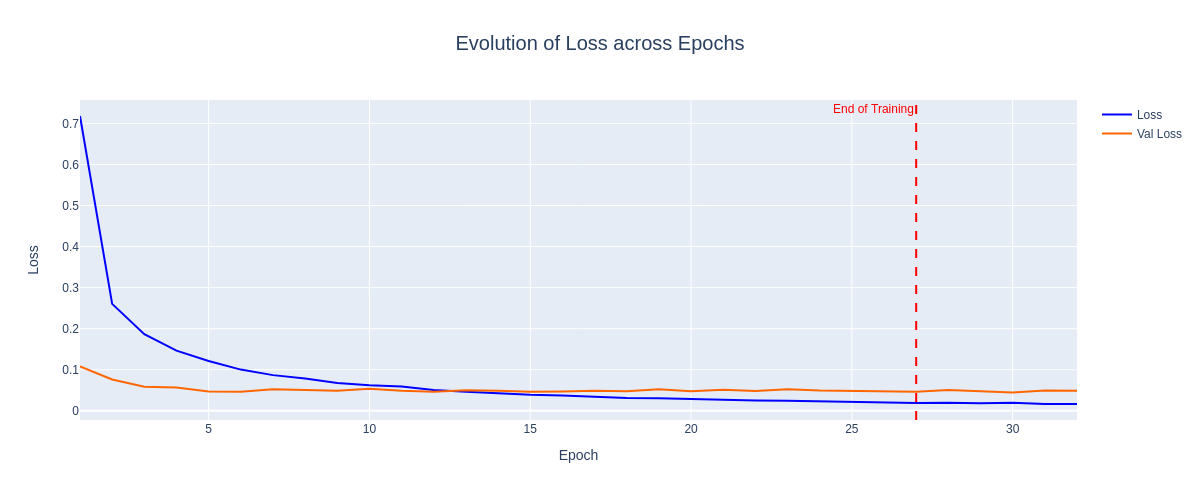

In [ ]:
# Static image for GitHub
plot_metrics(metric="accuracy", renderer="png")
plot_metrics(renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred, average='macro')}")

Accuracy: 0.9904
F1 Score: 0.9903906302049086


Frequency per Label: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000] 



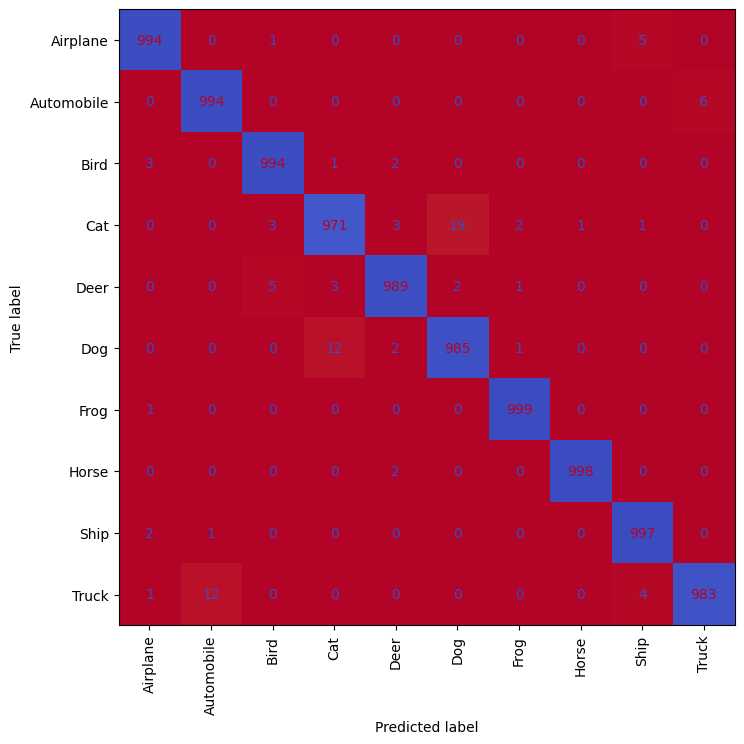

In [ ]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical");

The test dataset is balanced, with 1,000 images per label. Additionally, the confusion matrix indicates that the model has a slight difficulty distinguishing between the ``Cat``, ``Dog`` and ``Truck`` classes, while it correctly classified almost 100% of the ``Horse`` and ``Frog`` categories.

## **Predictions on the test dataset**

In [ ]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

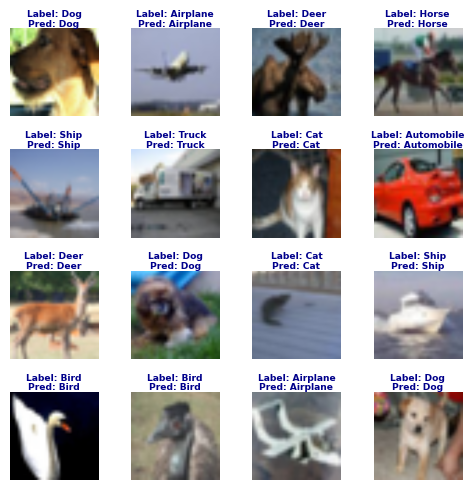

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=16)

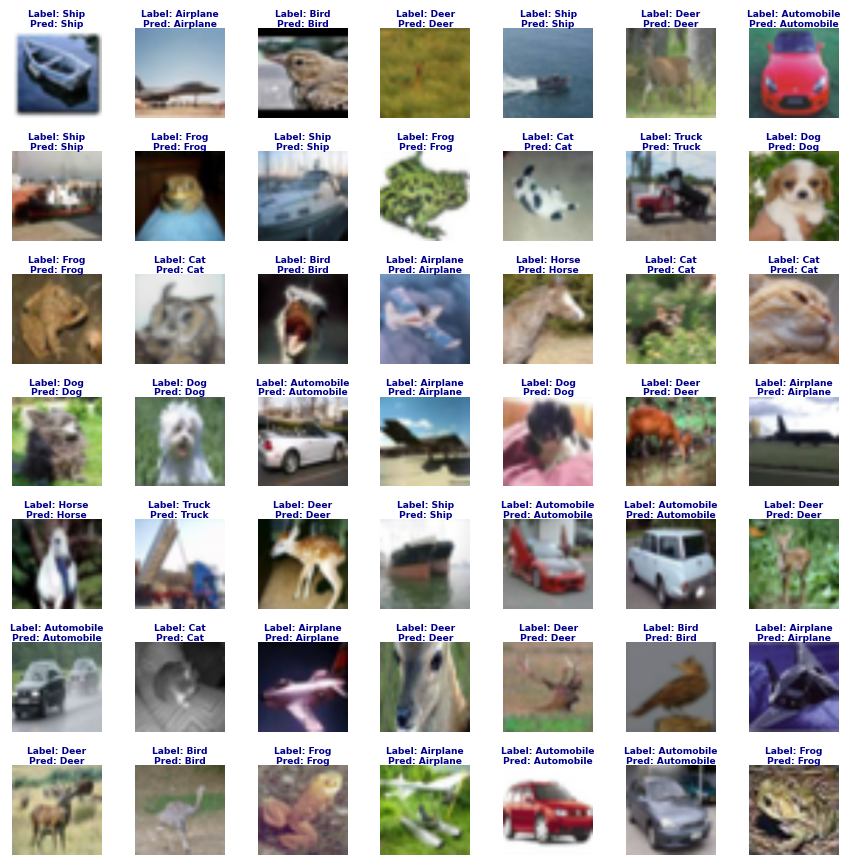

In [ ]:
show_images(
    images_test, labels_test, labels_test_pred, save=True,
    num_examples=49, path="Image_EfficientNetV2-XL_CIFAR-10"
)

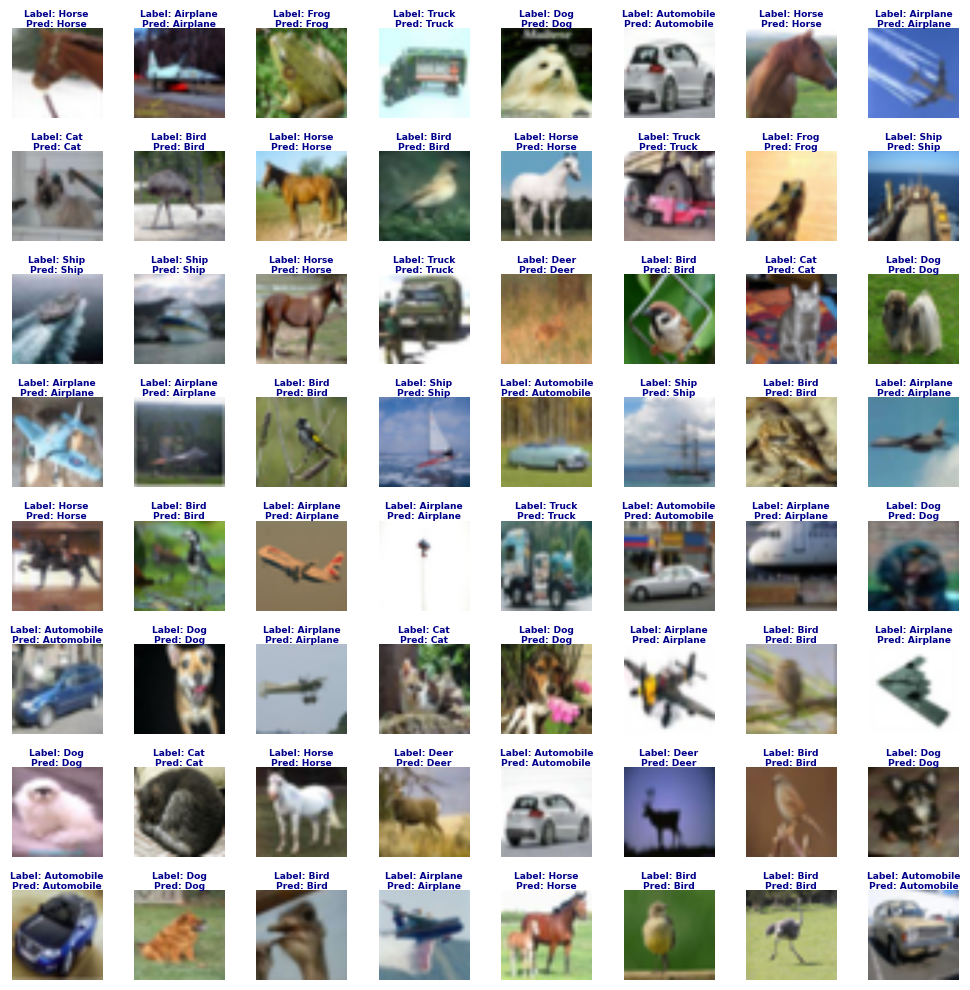

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=64, random=False)

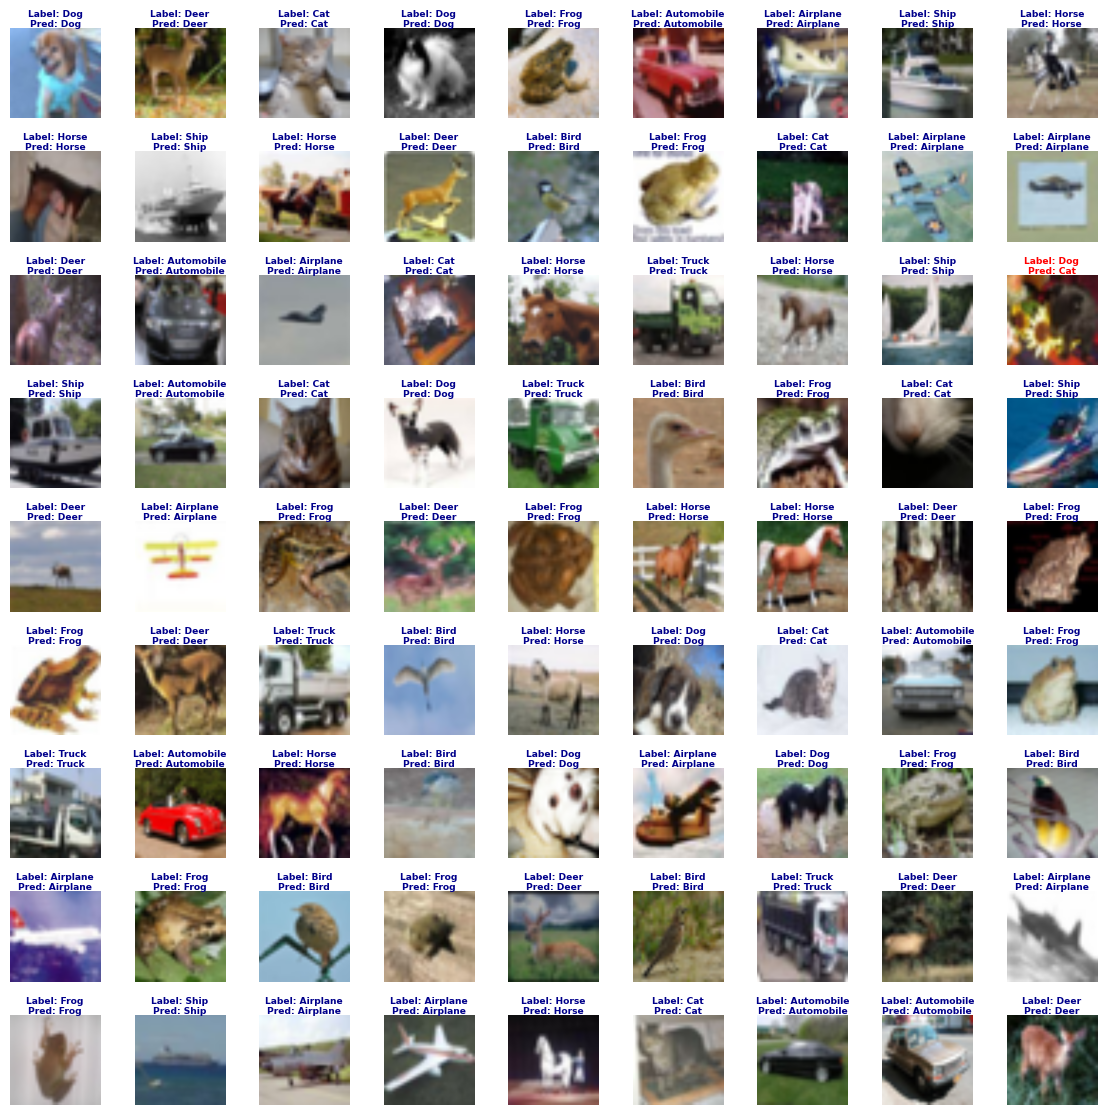

In [ ]:
# This image shows an incorrect prediction
show_images(images_test, labels_test, labels_test_pred, num_examples=81)

**Conclusion:** The model achieved an accuracy of **99.84%** on the training dataset and an accuracy and F1 score of **99.04%** on the test dataset. These results indicate that the model is highly effective at classifying images across the 10 classes of the CIFAR-10 dataset. Additionally, since the F1 score and accuracy on the test set are identical, it suggests that the model maintains a good balance between precision and recall. No overfitting is observed, indicating that the data augmentation techniques and the early stopping callback were effective. If training had continued for more epochs, the training accuracy would likely have reached 100%, while the test accuracy could have started to decrease or plateau. It is worth noting that for even better results, the official image size of 512x512 pixels should be used with the EfficientNetV2-XL model. However, this significantly slows down the fine-tuning process, even on Colab's TPU, requiring more tuning time and better computational resources. In this case, using an image size of 224x224 pixels is more than sufficient to achieve 99% accuracy on the test dataset.